In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
# Resize the images 32*32 as required by VGG16
X_train = tf.image.resize(np.array(X_train)[..., tf.newaxis], (32, 32))
X_train = np.repeat(X_train, 3, axis=-1)
X_test = tf.image.resize(np.array(X_test)[..., tf.newaxis], (32, 32))
X_test = np.repeat(X_test, 3, axis=-1)

# Change pixel values from (0, 255) to (0, 1)
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

In [5]:
X_train.shape, X_test.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
# Converting Labels to one hot encoded format
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

58889256/58889256 [==============================] - 10s 0us/step


In [8]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [9]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(
    X_train, y_train, epochs=8, verbose=1, batch_size=128, validation_split=0.2
)

Epoch 1/8
375/375 [==============================] - 141s 374ms/step - loss: 0.6183 - accuracy: 0.7891 - val_loss: 0.4714 - val_accuracy: 0.8282
Epoch 2/8
375/375 [==============================] - 140s 373ms/step - loss: 0.4317 - accuracy: 0.8444 - val_loss: 0.4326 - val_accuracy: 0.8400
Epoch 3/8
375/375 [==============================] - 140s 373ms/step - loss: 0.3943 - accuracy: 0.8555 - val_loss: 0.4163 - val_accuracy: 0.8460
Epoch 4/8
375/375 [==============================] - 140s 374ms/step - loss: 0.3724 - accuracy: 0.8648 - val_loss: 0.3960 - val_accuracy: 0.8545
Epoch 5/8
375/375 [==============================] - 139s 372ms/step - loss: 0.3546 - accuracy: 0.8699 - val_loss: 0.3818 - val_accuracy: 0.8619
Epoch 6/8
375/375 [==============================] - 145s 387ms/step - loss: 0.3399 - accuracy: 0.8742 - val_loss: 0.3949 - val_accuracy: 0.8558
Epoch 7/8
375/375 [==============================] - 139s 370ms/step - loss: 0.3280 - accuracy: 0.8784 - val_loss: 0.3704 - val_ac

In [11]:
results = model.evaluate(X_test, y_test)
print(results)

313/313 [==============================] - 27s 86ms/step - loss: 0.3751 - accuracy: 0.8643
[0.3750641345977783, 0.864300012588501]


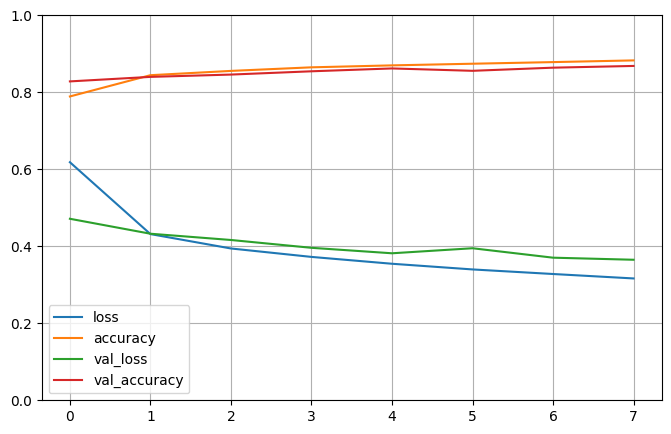

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [14]:
#let's do additional training of the last three layers
for i, layer in enumerate(model.layers):
    layer._name = 'layer_' + str(i)
    

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


modified_model = Sequential([
   conv_base,
   Flatten(),
   Dense(256, activation="relu"),
   Dense(10, activation="softmax"),
])

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


history = model.fit(
    X_train, y_train, epochs=2, verbose=1, batch_size=128, validation_split=0.2
)

Epoch 1/2
375/375 [==============================] - 155s 411ms/step - loss: 0.2877 - accuracy: 0.8949 - val_loss: 0.3524 - val_accuracy: 0.8732
Epoch 2/2
375/375 [==============================] - 142s 379ms/step - loss: 0.2835 - accuracy: 0.8963 - val_loss: 0.3521 - val_accuracy: 0.8724


In [16]:
results = model.evaluate(X_test, y_test)
print(results)

313/313 [==============================] - 28s 90ms/step - loss: 0.3613 - accuracy: 0.8710
[0.3613475561141968, 0.8709999918937683]


Висновок: порівнюючи звичайну згорткову мережу та згорткову мережу, що використовує VGG16 в якості згорткової основи, можемо помітити, що звичайна мережа показала вищу точність при однаковому розмірі батчу та однаковій кількості навчальних епох. VGG16 навіть з донавчанням трьох останніх шарів в 2 єпохи, не змогла показати точності звичайної згорткової мережі.